In [89]:
import networkit as nk
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import math
import threading

In [90]:
def GenGraphFromSubset(graph: nx.graph.Graph, community: list[int]) -> nx.Graph:
        subGraph = nx.Graph()
        subGraph.add_nodes_from(community)
        for node in community:
            for target in community:
                if graph.has_edge(node,target):
                    subGraph.add_edge(node,target)
                    pass
                pass
            pass
        return subGraph

def LoadFeatures(graph : nx.Graph, jsonFile : str):
    file = open(jsonFile,"r")
    jsonValues = json.load(file)
    trValues= {}
    for i in range(len(jsonValues)):
        trValues[i] = [] 
        for value in jsonValues[str(i)]:
            trValues[i].append(value)  
            pass
        pass
    nx.set_node_attributes(graph,trValues)
    pass

def LoadTarget(graph: nx.graph.Graph,targetFile):
    tg = pd.read_csv(targetFile)
    ml_target = {}
    usernames= {}
    for i in range(graph.number_of_nodes()):
        ml_target[i] = tg["ml_target"][i]
        usernames[i] = tg["name"][i]
        pass
    nx.set_node_attributes(graph,ml_target,"ml_target")
    nx.set_node_attributes(graph,usernames,"username")
    pass

def PrintStat(array: list[int]):
    print("Mean: " + str(np.mean(array)))
    print("Max: " + str(np.max(array)))
    print("Min: " + str(np.min(array)))
    print("Variance: " + str(np.var(array)))
    pass






In [3]:

graph = nk.graphio.EdgeListReader(",",0).read("./musae_git_edges.csv")
nxgraph = nk.nxadapter.nk2nx(graph)
LoadTarget(nxgraph,"./musae_git_target.csv")

Basic Measure

In [26]:
density = nxgraph.number_of_nodes()/nxgraph.number_of_edges()
density

0.13044847285322297

Degree

Mean: 15.331724137931035
Max: 9458
Min: 1
Variance: 6526.544335754138


(array([3.7676e+04, 1.7000e+01, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 9.4670e+02, 1.8924e+03, 2.8381e+03, 3.7838e+03,
        4.7295e+03, 5.6752e+03, 6.6209e+03, 7.5666e+03, 8.5123e+03,
        9.4580e+03]),
 <BarContainer object of 10 artists>)

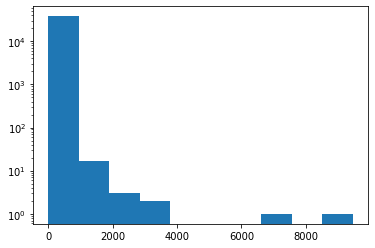

In [84]:
degrees = [degree[1] for degree in nxgraph.degree()]
PrintStat(degrees)
plt.hist(degrees,log=True)

In [4]:

def NKExtractDistances(graph: nk.graph.Graph, node : int, dict :dict[int,list[int]]) -> None:
    distances = []
    bfs = nk.distance.BFS(graph,node)
    bfs.run()
    for nodeT in nxgraph:
        if node != nodeT:
            distances.append(bfs.distance(nodeT))
        pass
    dict[node] = distances
    

globDistances = {}
for node in nxgraph:
    NKExtractDistances(graph,node,globDistances)
    pass


globDistances


In [77]:
clusteringCoeff = nx.clustering(nxgraph)


Mean: 0.16753704480107584
Max: 1.0
Min: 0.0
Variance: 0.05069908888488433


(array([18619.,  7831.,  4329.,  2989.,   874.,   817.,   721.,    35.,
           91.,  1394.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

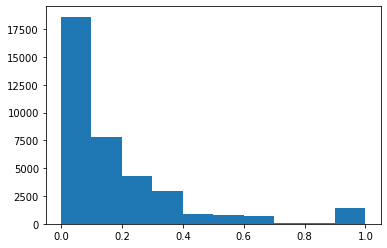

In [78]:
coeff = [val for val in clusteringCoeff.values()]

plt.hist(coeff)


In [30]:
nx.components.is_connected(nxgraph)

True

the graph is connected, so the whole graph is the giant connected component

Distances

In [92]:
bfs = nk.distance.BFS(graph,0)
bfs.run()
nkdistances = bfs.getDistances()

Mean: 3.6359151193633954
Max: 8.0
Min: 0.0
Variance: 0.35508145698625887


(array([1.0000e+00, 1.0000e+00, 3.1000e+01, 1.5812e+04, 1.9825e+04,
        1.9130e+03, 1.1000e+02, 6.0000e+00, 1.0000e+00]),
 array([0.        , 0.88888889, 1.77777778, 2.66666667, 3.55555556,
        4.44444444, 5.33333333, 6.22222222, 7.11111111, 8.        ]),
 <BarContainer object of 9 artists>)

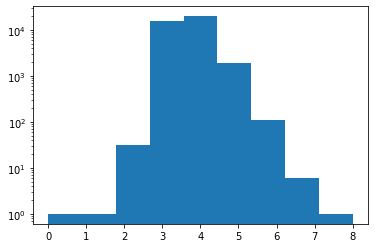

In [103]:
PrintStat(nkdistances)
plt.hist(nkdistances,log=True,bins=9)

Centralities

In [11]:
closeness = nk.centrality.Closeness(graph,False,False)
closeness.run()


Mean: 0.313667247491002
Max: 0.5230814058359118
Min: 0.1413885700998372
Variance: 0.001665102448375804


(array([6.000e+00, 5.000e+00, 4.100e+01, 7.900e+01, 2.830e+02, 7.000e+02,
        9.120e+02, 2.074e+03, 3.555e+03, 5.363e+03, 5.093e+03, 3.921e+03,
        1.309e+03, 8.852e+03, 2.719e+03, 1.978e+03, 6.940e+02, 9.000e+01,
        1.500e+01, 5.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00]),
 array([0.14138857, 0.15665628, 0.171924  , 0.18719171, 0.20245942,
        0.21772714, 0.23299485, 0.24826256, 0.26353028, 0.27879799,
        0.2940657 , 0.30933342, 0.32460113, 0.33986884, 0.35513656,
        0.37040427, 0.38567198, 0.4009397 , 0.41620741, 0.43147513,
        0.44674284, 0.46201055, 0.47727827, 0.49254598, 0.50781369,
        0.52308141]),
 <BarContainer object of 25 artists>)

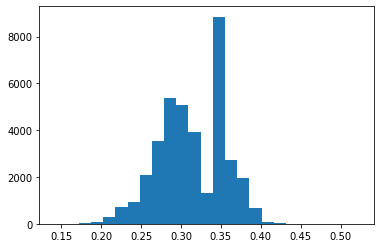

In [85]:
PrintStat(closeness.scores())
plt.hist(closeness.scores(),25)

Betwenness through estimation: The algorithm estimates the betweenness of all nodes, using weighting of the contributions to avoid biased estimation. The run() method takes O(m) time per sample, where m is the number of edges of the graph. There is no proven theoretical guarantee on the quality of the approximation. However, the algorithm was shown to perform well in practice. If a guarantee is required, use ApproxBetweenness. 

In [20]:
ebtw = nk.centrality.EstimateBetweenness(graph,100)
ebtw.run()

Mean: 83928.20999999989
Max: 410502104.5364349
Min: 0.0
Variance: 8489001059788.457


(array([3.7625e+04, 4.3000e+01, 1.1000e+01, 5.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

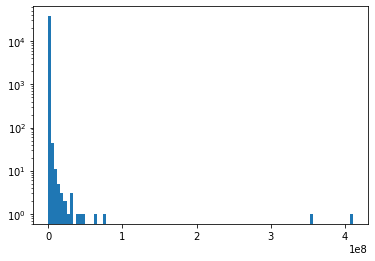

In [86]:
PrintStat(ebtw.scores())
plt.hist(ebtw.scores(),100,log=True)

In [87]:

btw = nk.centrality.Betweenness(graph)
btw.run()

Mean: 84687.37310344815
Max: 383148252.27699816
Min: 0.0
Variance: 7679228493117.37


Mean: 84687.37310344815
Max: 383148252.276998
Min: 0.0
Variance: 7679228493117.379


(array([3.7638e+04, 3.3000e+01, 5.0000e+00, 8.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

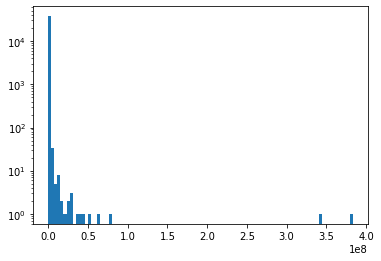

In [88]:
PrintStat(btw.scores())
plt.hist(btw.scores(),100,log=True)

Degree Correlation

In [32]:
nx.assortativity.degree_assortativity_coefficient(nxgraph)

-0.07521713413904481

In [36]:
cross_edges = 0
mlTargets = nx.get_node_attributes(nxgraph,"ml_target")
for node in nxgraph:
    for target in nxgraph:
        if nxgraph.has_edge(node,target):
            if mlTargets[node] != mlTargets[target]:
                cross_edges += 1
                pass
            pass
        pass
    pass
cross_edges

89392

In [48]:
ml = len([t for t in mlTargets.values() if t > 0])
web = len([t for t in mlTargets.values() if t == 0])
print("Number of ml: " + str(ml))
print("Number of web: "+ str(web))
print("Number of cross edges: " + str(cross_edges))
cross_edges < 2*ml*web

Number of ml: 9739
Number of web: 27961
Number of cross edges: 89392


True

In [ ]:
degrees = [degree[1] for degree in nxgraph.degree()]
degreeOnRange = {}
for degree in range(np.max(degrees)):
    degreeOnRange[degree] = np.mean([dgT for dgT in degrees if dgT > degree])
    pass



        


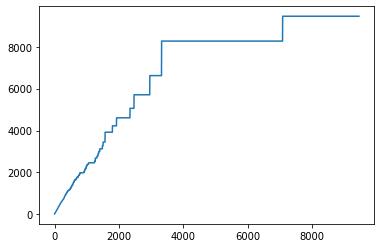

In [61]:
plt.plot(degreeOnRange.keys(), degreeOnRange.values())

Chapter communities

In [70]:
louvainComms = nx.community.louvain_communities(nxgraph)
nx.algorithms.community.modularity(nxgraph,louvainComms)

0.45416683163068516

In [69]:
labelComms = nx.community.label_propagation_communities(nxgraph)
nx.algorithms.community.modularity(nxgraph,labelComms)

0.002918446982036539

In [75]:
def AnalyzeCommunityResults(nxgraph : nx.graph.Graph, communities):
    index = 0
    for community in communities:
        if len(community) >= nxgraph.size()/2:
            break
        commgraph = GenGraphFromSubset(nxgraph,community)
        print("Number of nodes: " + str(len(community)))
        mlTargets = nx.get_node_attributes(nxgraph,"ml_target")
        totalTarget = 0
        colormap = []
        for node in community:
            totalTarget += mlTargets[node]
            if mlTargets[node] == 1:
                    colormap.append('red')
                    pass
            else:
                colormap.append('blue')
                pass
        print("Number of MLTargets: " + str(totalTarget))
        if len(community) < 1000:
            pos = nx.circular_layout(commgraph)
            nx.draw(commgraph,pos,node_color=colormap)
            plt.show()
            pass
    index += 1
pass


In [ ]:
AnalyzeCommunityResults(nxgraph,louvainComms)

In [ ]:
AnalyzeCommunityResults(nxgraph,labelComms)